The main objective of the notebook is to build a classification model using bag of words features

### Import Libraries

In [11]:
import pandas as pd                                         #data processing
import re                                                   #regular expression for data cleaning
from sklearn.feature_extraction.text import CountVectorizer #feature extraction
import nltk                                                 #natural language toolkit
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 200)

### Load Dataset

In [12]:
data=pd.read_csv("tweets.csv") 

Let us print information about a dataframe including the index, dtype and column dtypes.

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
id       7920 non-null int64
label    7920 non-null int64
tweet    7920 non-null object
dtypes: int64(2), object(1)
memory usage: 185.8+ KB


Display first 5 rows

In [14]:
data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!


check for null values since machine learning algorithm do not suppport data with missing values

In [15]:
data.isnull().sum() #check for the null values

id       0
label    0
tweet    0
dtype: int64

Dropping out the column with ID since it doesn't contribute to the output

In [16]:
data = data.drop(['id'],axis=1) #drop unnecessary columns

Understanding the class distribution helps in knowing whether the dataset is balanced or 
not.

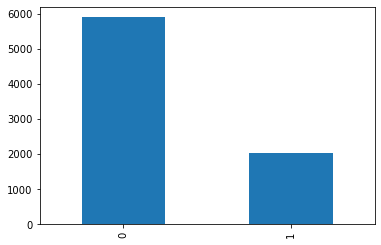

In [17]:
data['label'].value_counts().plot(kind='bar')

Lets us understand the proportion of each class

In [18]:
data['label'].value_counts(normalize=True)

0    0.744192
1    0.255808
Name: label, dtype: float64

We can infer that the given problem is a class imbalance problem

### Pre Processing the text

1.The raw data is messy. It contains hashtags, user mentions, non ascii characters, punctuations, numbers, html entities, extra spaces, misspelled words,etc.

2.So, Data Pre-processing is the most important step prior to the model building in which we remove all the unnecessary qualities from the data.

Let us look at some of the examples

__Contraction mapping:__ expanding the shortened versions or contraction of words using contraction dictionary

In [20]:
data.tweet[24]

"It's time for new wallpapers #phone #wallpapers #wall #screen #galaxy #samsung #app … https://www.instagram.com/p/BcsKTNNn51c/"

In [21]:
newString=re.sub(r"'s\b"," is",data.tweet[24])  #converting It's to It is
newString

'It is time for new wallpapers #phone #wallpapers #wall #screen #galaxy #samsung #app … https://www.instagram.com/p/BcsKTNNn51c/'

__Removing user mention__

In [22]:
data.tweet[11]

'Ha! Not heavy machinery but it does what I need it to. @Apple really dropped the ball with that design. #drinkyourhaterade'

In [23]:
newString=re.sub(r'@[A-Za-z0-9]+','',data.tweet[11])
print(newString)

Ha! Not heavy machinery but it does what I need it to.  really dropped the ball with that design. #drinkyourhaterade


__Removing hashtag symbol__

In [24]:
data.tweet[0]

'#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone'

In [25]:
newString=re.sub("#","",data.tweet[0])
print(newString)

fingerprint Pregnancy Test https://goo.gl/h1MfQV android apps beautiful cute health igers iphoneonly iphonesia iphone


__Removal of links__

In [26]:
data.tweet[1]

'Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/'

In [27]:
newString=re.sub(r'http\S+', '', data.tweet[1])
newString

'Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… '

__Removing special characters, punctuations, numbers__

In [28]:
data.tweet[25]

'1.05 billion for 3 patents where there is prior art = 300 millions each = patent trolls are partying now thanks to Apple #apple'

In [29]:
newString=re.sub("[^a-zA-Z]", " ", data.tweet[25])
newString

'     billion for   patents where there is prior art       millions each   patent trolls are partying now thanks to Apple  apple'

<br>
Now let's use these techniques on the entire dataset.

In [30]:
# make a dictionary of contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [31]:
# function to pre-process text
def tweet_cleaner(text):
    newString=re.sub(r'@[A-Za-z0-9]+','',text)                     #removing user mentions
    newString=re.sub("#","",newString)                             #removing hashtag symbol
    newString= ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) #contraction mapping
    newString= re.sub(r'http\S+', '', newString)                   #removing links
    newString= re.sub(r"'s\b","",newString)                        #removing 's
    letters_only = re.sub("[^a-zA-Z]", " ", newString)             #Fetching out only letters
    lower_case = letters_only.lower()                              #converting everything to lowercase
    words = lower_case.split()                                     #split based on space to remove multiple spaces                                
    return (" ".join(words)).strip()                               #combining to form sentence

In [32]:
# empty list to store the cleaned tweets
cleaned_tweets = []

for i in data.tweet:
  cleaned_tweets.append(tweet_cleaner(i))

print(cleaned_tweets[:5])   #print top 5 records

['fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone', 'finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias', 'we love this would you go talk makememories unplug relax iphone smartphone wifi connect', 'i am wired i know i am george i was made that way iphone cute daventry home', 'what amazing service apple will not even talk to me about a question i have unless i pay them for their stupid support']


In [33]:
data['cleaned_tweets']=cleaned_tweets  #creating new column 

### Explore the Data

Let us understand the most commonly used words in the text before cleaning

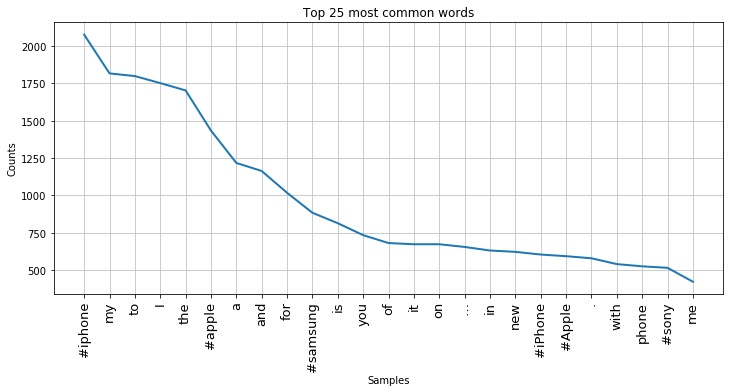

In [34]:
all_words = []
for line in list(data['tweet']):
    words = line.split()
    for word in words:
        all_words.append(word)
        
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)      

From above plot, we can infer that most of the tweets are related to iphone, apple, samsung, sony but punctuations are also included in top common words.

Let us visualize the same plot after preprocessing

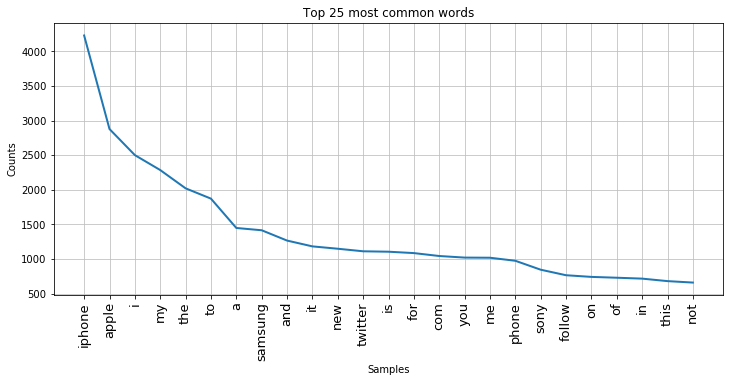

In [35]:
all_words = []
for line in list(data['cleaned_tweets']):
    words = line.split()
    for word in words:
        all_words.append(word)
        
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)      

**Model building**

Bag of Words features

Here, frequency of every word in vocabulary is calculated and used to build the feature space.

In [36]:
vectorizer = CountVectorizer()
features= vectorizer.fit_transform(data['cleaned_tweets'])
features.shape

(7920, 16878)

Every word in the vocabulary is a feature

Split the dataset into training and validation set

In [37]:
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(features,data['label'],test_size=0.3,random_state=42) 

Train Logistic Regression

In [38]:
lr = LogisticRegression()           #instantiate model

lr.fit(xtrain_bow, ytrain)          #training model

prediction = lr.predict(xvalid_bow) #predicting on validation set

f1_score(yvalid, prediction)        #calculating f1 score

0.767275615567911

We have seen the steps for cleaning the text and how to build a classifier using bag of words features.